In [1]:
import numpy as np
import imageio as im
from os import listdir
from os.path import isfile, join
import re
import io
import pickle

import imageio
from PIL import Image, ImageDraw, ImageFilter

import matplotlib
import matplotlib.pyplot as plt

In [2]:
envs=[
    "AirRaidNoFrameskip-v4"
    ,"CarnivalNoFrameskip-v4"
    ,"DemonAttackNoFrameskip-v4"
    ,"NameThisGameNoFrameskip-v4"
    ,"PongNoFrameskip-v4"
    ,"SpaceInvadersNoFrameskip-v4"
]
models=[
    "AirRaid"
    , "Carnival"
    , "DemonAttack"
    , "NameThisGame"
    , "Pong"
    , "SpaceInvaders"
    , "MultiTask"
    , "MultiTaskPopart"
]

In [299]:
for model in models:
    path = "../logs/torchbeast/" + model + "/movies/play_raw/"
    filenames = [f for f in listdir(path) if isfile(join(path, f))]
    filenames = np.sort(filenames)
    filenames = filenames[filenames != ".DS_Store"]
    
    for env in envs:
        regex = re.compile(".*" + env + ".*")
        mfilenames = [string for string in filenames if re.match(regex, string)]
        if len(mfilenames) > 0:
            moviefilename = path.replace("play_raw/", "") + mfilenames[0].replace("_00000.png", ".gif")
            with imageio.get_writer(moviefilename, mode='I', duration = 0.05) as writer:
                for filename in mfilenames:
                    image = imageio.imread(path + filename)
                    writer.append_data(image)

In [573]:
path = "../logs/torchbeast/actions/"
filenames = [f for f in listdir(path) if isfile(join(path, f))]
filenames = np.sort(filenames)
filenames = filenames[filenames != ".DS_Store"]
actions = []
for filename in filenames:
    actions.append(sum(1 for line in open(path + filename)))

for model in models:
    path = "../logs/torchbeast/" + model + "/movies/saliency_raw/"
    filenames = [f for f in listdir(path) if isfile(join(path, f))]
    filenames = np.sort(filenames)
    filenames = filenames[filenames != ".DS_Store"]
    
    for i in range(len(envs)):
        env = envs[i]
        regex = re.compile("Saliency_.*" + env + ".*")
        mfilenames = [string for string in filenames if re.match(regex, string)]
        if len(mfilenames) > 0:
            print(model, env, len(mfilenames) / actions[i] * 100.)

AirRaid AirRaidNoFrameskip-v4 100.0
Carnival CarnivalNoFrameskip-v4 100.0
DemonAttack DemonAttackNoFrameskip-v4 100.0
NameThisGame NameThisGameNoFrameskip-v4 100.0
Pong PongNoFrameskip-v4 100.0
SpaceInvaders SpaceInvadersNoFrameskip-v4 100.0
MultiTask AirRaidNoFrameskip-v4 100.0
MultiTask CarnivalNoFrameskip-v4 100.0
MultiTask DemonAttackNoFrameskip-v4 100.0
MultiTask NameThisGameNoFrameskip-v4 100.0
MultiTask PongNoFrameskip-v4 100.0
MultiTask SpaceInvadersNoFrameskip-v4 100.0
MultiTaskPopart AirRaidNoFrameskip-v4 100.0
MultiTaskPopart CarnivalNoFrameskip-v4 100.0
MultiTaskPopart DemonAttackNoFrameskip-v4 100.0
MultiTaskPopart NameThisGameNoFrameskip-v4 100.0
MultiTaskPopart PongNoFrameskip-v4 100.0
MultiTaskPopart SpaceInvadersNoFrameskip-v4 100.0


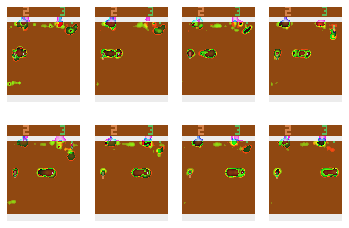

In [34]:
quantile=80
cutoff = max(0., 255. - (256. * quantile / 100.))
for model in models[-2:-1]:
    path = "../logs/torchbeast/" + model + "/movies/saliency_raw/"
    filenames = [f for f in listdir(path) if isfile(join(path, f))]
    filenames = np.sort(filenames)
    filenames = filenames[filenames != ".DS_Store"]
    
    for env in envs[4:5]:
        regex = re.compile("Saliency_.*" + env + ".*")
        mfilenames = [string for string in filenames if re.match(regex, string)]
        if len(mfilenames) > 0:

            fig, axes = plt.subplots(2, 4, figsize=(6,4))
            for i in range(2):
                for j in range(4):
                    k = i * 4 + j

                    filename = mfilenames[2*k+4]
                    atari = Image.open(path + filename.replace("Saliency", "Atari"))

                    saliency = Image.open(path + filename)
                    saliency = np.array(saliency)
                    idx = saliency > cutoff
                    saliency_cutoff = np.zeros_like(saliency)
                    saliency_cutoff[idx] = saliency[idx]

                    saliency_modified = np.zeros_like(saliency)
                    saliency_modified[:,:,0] = saliency_cutoff[:,:,0]
                    saliency_modified[:,:,1] = saliency_cutoff[:,:,2]
                    
                    atari = np.array(atari) + saliency_modified
                    axes[i, j].imshow(atari)
                    axes[i, j].set_axis_off()
plt.savefig("fig_saliency_pong.png", bbox_inches="tight", dpi=300) 
plt.show() 

In [10]:
flatten = lambda l: [item for sublist in l for item in sublist]
allfilenames = []
for model in models:
    path = "../logs/torchbeast/" + model + "/movies/saliency_raw_actions/"
    filenames = [path + f for f in listdir(path) if isfile(join(path, f))]
    filenames = np.sort(filenames)
    filenames = filenames[filenames != ".DS_Store"]
    allfilenames.append(filenames)
allfilenames = flatten(allfilenames)

quantile=80
cutoff = max(0., 255. - (256. * quantile / 100.))
for env in envs:

    moviefilename = "./Saliency_" + env + ".gif"
    with imageio.get_writer(moviefilename, mode='I', duration = 0.1) as writer:

        filenames = []
        regex = re.compile(".*/" + env.replace("NoFrameskip-v4", "") + "/.*/Saliency_.*" + env + ".*")
        filenames.append([string for string in allfilenames if re.match(regex, string)])
        regex = re.compile(".*/MultiTask/.*/Saliency_.*" + env + ".*")
        filenames.append([string for string in allfilenames if re.match(regex, string)])
        regex = re.compile(".*/MultiTaskPopart/.*/Saliency_.*" + env + ".*")
        filenames.append([string for string in allfilenames if re.match(regex, string)])
        
        title = ["Single-task", "Multi-task", "Multi-task PopArt"]
        n = len(filenames)
        for i in range(min(len(filenames[0]), len(filenames[1]), len(filenames[2]))):
            
            fig, axes = plt.subplots(1, n+1, figsize=(13.25,4.41))
            for j in range(n):
                filename = filenames[j][i]
                atari = Image.open(filename.replace("Saliency", "Atari"))
                atari_orig = atari.copy()

                saliency = Image.open(filename)
                saliency = np.array(saliency)
                idx = saliency > cutoff
                
                saliency_cutoff = np.zeros_like(saliency)
                saliency_cutoff[idx] = saliency[idx]

                saliency_modified = np.zeros_like(saliency)
                saliency_modified[:,:,0] = saliency_cutoff[:,:,0]
                saliency_modified[:,:,1] = saliency_cutoff[:,:,2]

                atari = np.array(atari) + saliency_modified
                
                axes[j+1].imshow(atari)
                axes[j+1].title.set_text(title[j])
                axes[j+1].set_axis_off()    

            axes[0].imshow(atari_orig)
            axes[0].title.set_text(env.replace("NoFrameskip-v4", ""))
            axes[0].set_axis_off()    
            
            buf = io.BytesIO()
            plt.savefig(buf, bbox_inches="tight", format='png')
            plt.close(fig)
            buf.seek(0)
            image = imageio.imread(buf)
            buf.close()
            writer.append_data(image)     

50.19999999999999


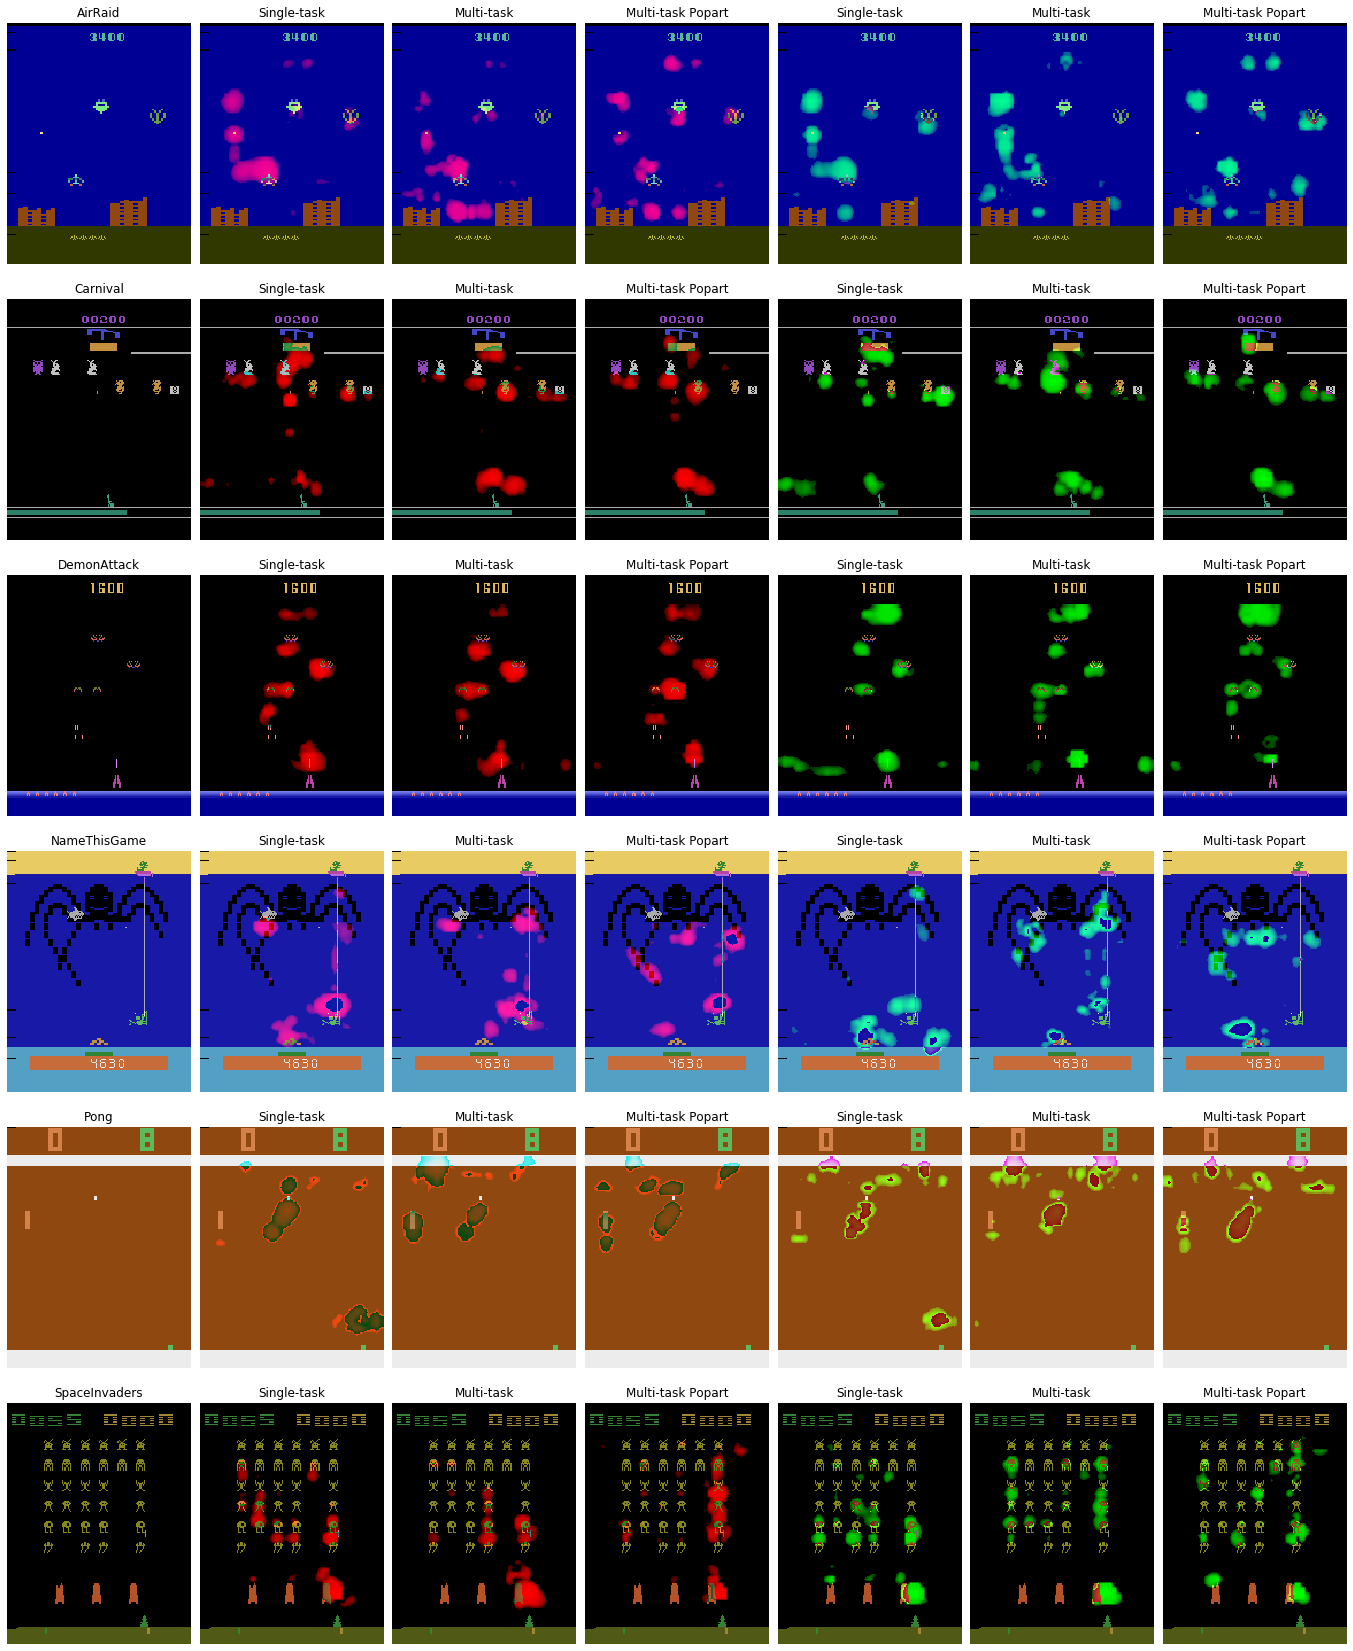

In [35]:
flatten = lambda l: [item for sublist in l for item in sublist]
allfilenames = []
for model in models:
    path = "../logs/torchbeast/" + model + "/movies/saliency_raw_actions/"
    filenames = [path + f for f in listdir(path) if isfile(join(path, f))]
    filenames = np.sort(filenames)
    filenames = filenames[filenames != ".DS_Store"]
    allfilenames.append(filenames)
allfilenames = flatten(allfilenames)

frames = {
    "AirRaidNoFrameskip-v4": 980
    , "CarnivalNoFrameskip-v4": 104
    , "DemonAttackNoFrameskip-v4": 1147
    , "NameThisGameNoFrameskip-v4": 2912 
    , "PongNoFrameskip-v4": 921
    , "SpaceInvadersNoFrameskip-v4": 100
}

quantile=80
cutoff = max(0., 255. - (256. * quantile / 100.))
print(cutoff)

fig, axes = plt.subplots(6, 7, figsize=(24,30))
i = 0
for env in frames.keys():

    filenames = []
    regex = re.compile(".*/" + env.replace("NoFrameskip-v4", "") + "/.*/Saliency_.*" + env + ".*" + str(frames[env]).zfill(5) + ".*")
    filenames.append([string for string in allfilenames if re.match(regex, string)])
    regex = re.compile(".*/MultiTask/.*/Saliency_.*" + env + ".*" + str(frames[env]).zfill(5) + ".*")
    filenames.append([string for string in allfilenames if re.match(regex, string)])
    regex = re.compile(".*/MultiTaskPopart/.*/Saliency_.*" + env + ".*" + str(frames[env]).zfill(5) + ".*")
    filenames.append([string for string in allfilenames if re.match(regex, string)])

    title = ["Single-task", "Multi-task", "Multi-task Popart"]
    n = len(filenames)
    for j in range(3):
        filename = filenames[j][0]
        atari = Image.open(filename.replace("Saliency", "Atari"))
        atari_orig = atari.copy()

        saliency = Image.open(filename)
        saliency = np.array(saliency)
        idx = saliency > cutoff
        saliency_modified = np.zeros_like(saliency)
        saliency_modified[idx] = saliency[idx]
        
        saliency_modified1 = np.zeros_like(saliency_modified)
        saliency_modified2 = np.zeros_like(saliency_modified)
        
        saliency_modified1[:,:,0] = saliency_modified[:,:,0]
        saliency_modified2[:,:,1] = saliency_modified[:,:,2]
        
        atari1 = np.array(atari) + saliency_modified1
        atari2 = np.array(atari) + saliency_modified2

        axes[i, j+1].imshow(atari1)
        axes[i, j+1].title.set_text(title[j])
        axes[i, j+1].set_axis_off()    

        axes[i, j+4].imshow(atari2)
        axes[i, j+4].title.set_text(title[j])
        axes[i, j+4].set_axis_off()    

        axes[i, 0].imshow(atari_orig)
        axes[i, 0].title.set_text(env.replace("NoFrameskip-v4", ""))
        axes[i, 0].set_axis_off()
    i = i + 1
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig("fig_saliency.png", bbox_inches="tight", dpi=300) 
#plt.show()